In [1]:
# Socio-Clinical Depression Assessment System — Feature Engineering & Selection

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif

sns.set(style="whitegrid", palette="viridis", font_scale=1.1)
print("✅ Libraries loaded successfully!")


✅ Libraries loaded successfully!


In [2]:
BASE_DIR = os.path.abspath("..")
DATA_PROCESSED = os.path.join(BASE_DIR, "data", "processed")
data_path = os.path.join(DATA_PROCESSED, "mhp_cleaned.csv")

df = pd.read_csv(data_path)
print(f"✅ Cleaned dataset loaded! Shape: {df.shape}")
df.head()


✅ Cleaned dataset loaded! Shape: (2028, 39)


,Age,Gender,University,Department,Academic_Year,Current_CGPA,waiver_or_scholarship,PSS1,PSS2,PSS3,...,PHQ2,PHQ3,PHQ4,PHQ5,PHQ6,PHQ7,PHQ8,PHQ9,Depression_Value,Depression_Label
0,18-22,0,8,2,3,2.50 - 2.99,0,3,4,3,...,2,3,2,2,2,2,3,2,20,5
1,18-22,1,8,2,4,3.00 - 3.39,0,3,3,4,...,2,2,2,2,2,2,2,2,19,3
2,18-22,1,0,2,4,3.00 - 3.39,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,18-22,1,0,2,4,3.00 - 3.39,0,3,1,2,...,1,2,1,2,1,2,2,1,14,2
4,18-22,1,10,2,3,2.50 - 2.99,0,4,4,4,...,3,3,3,1,3,0,3,3,20,5


In [3]:
target_col = "Depression_Label"

# Separate target and features
y = df[target_col]
X = df.drop(columns=[target_col])

print(f"✅ Features shape: {X.shape} | Target shape: {y.shape}")


✅ Features shape: (2028, 38) | Target shape: (2028,)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")


Training set: (1622, 38), Testing set: (406, 38)


In [5]:
scaler = StandardScaler()

# Select numeric columns only for scaling
num_cols = X_train.select_dtypes(include=np.number).columns
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

print("✅ Numeric features scaled successfully!")


✅ Numeric features scaled successfully!


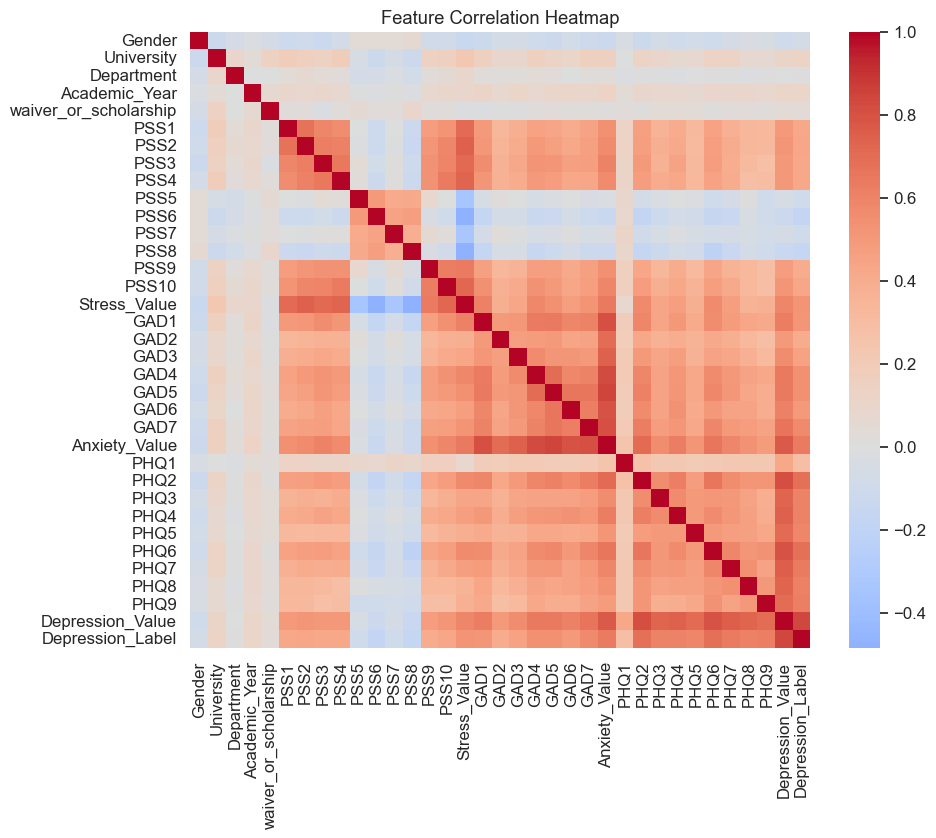

🔎 Top correlations with Depression_Value:
Depression_Value    1.000000
Depression_Label    0.832677
PHQ2                0.810137
PHQ6                0.797408
Anxiety_Value       0.769706
PHQ7                0.755087
PHQ4                0.750082
PHQ3                0.730538
PHQ8                0.729416
PHQ5                0.706853
Name: Depression_Value, dtype: float64


In [6]:
plt.figure(figsize=(10,8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

# Show top correlations with Depression_Value
if "Depression_Value" in df.columns:
    corr_target = corr["Depression_Value"].sort_values(ascending=False)
    print("🔎 Top correlations with Depression_Value:")
    print(corr_target.head(10))


In [10]:
from sklearn.preprocessing import LabelEncoder

# Identify non-numeric columns
non_numeric_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
print("🧩 Non-numeric columns detected:", non_numeric_cols)

# Encode them numerically using LabelEncoder
le = LabelEncoder()
for col in non_numeric_cols:
    combined = pd.concat([X_train[col], X_test[col]])
    le.fit(combined.astype(str))
    X_train[col] = le.transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))

print("✅ All categorical columns encoded numerically!")


🧩 Non-numeric columns detected: ['Age', 'Current_CGPA', 'Stress_Label', 'Anxiety_Label']
✅ All categorical columns encoded numerically!


In [11]:
selector = SelectKBest(score_func=f_classif, k=10)
selector.fit(X_train, y_train)

selected_indices = selector.get_support(indices=True)
selected_features = X_train.columns[selected_indices]
feature_scores = selector.scores_[selected_indices]

print("✅ Top 10 features (ANOVA F-test):")
for f, s in zip(selected_features, feature_scores):
    print(f"{f}: {s:.3f}")


✅ Top 10 features (ANOVA F-test):
Anxiety_Value: 415.827
Anxiety_Label: 279.350
PHQ2: 575.056
PHQ3: 317.443
PHQ4: 416.975
PHQ5: 287.069
PHQ6: 522.054
PHQ7: 369.899
PHQ8: 332.742
Depression_Value: 5103.646


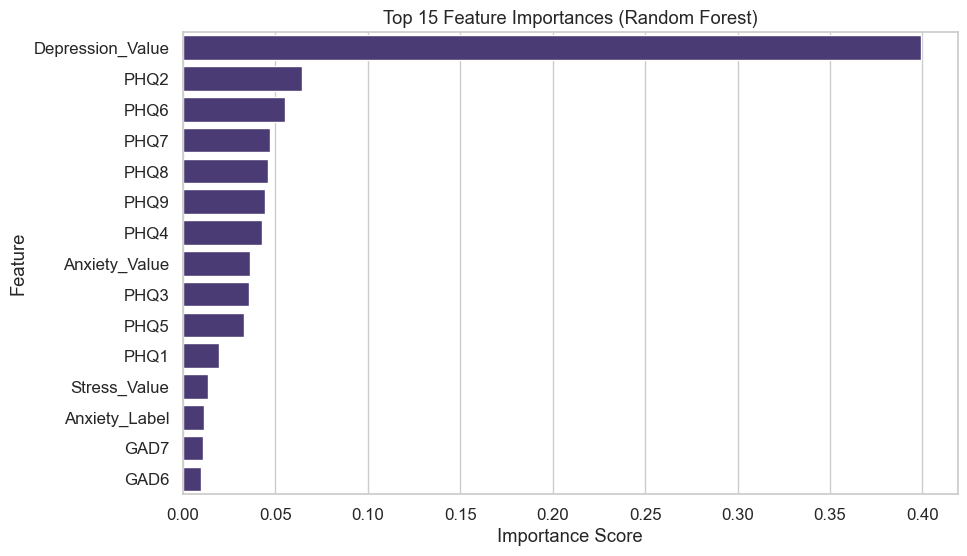

✅ Random Forest feature importance calculated!


In [12]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=importances.head(15), y=importances.head(15).index)
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

print("✅ Random Forest feature importance calculated!")


In [13]:
# Combine top features from both methods
selected_set = set(selected_features.tolist() + importances.head(15).index.tolist())
final_features = list(selected_set)

print(f"✅ Total selected features: {len(final_features)}")
print(final_features)

# Save feature list
feature_list_path = os.path.join(BASE_DIR, "models", "feature_list.txt")
os.makedirs(os.path.dirname(feature_list_path), exist_ok=True)

with open(feature_list_path, "w") as f:
    for feat in final_features:
        f.write(f"{feat}\n")

print(f"📁 Saved selected features to: {feature_list_path}")


✅ Total selected features: 15
['PHQ9', 'PHQ7', 'PHQ5', 'PHQ3', 'PHQ8', 'PHQ1', 'GAD7', 'PHQ4', 'PHQ2', 'GAD6', 'Anxiety_Label', 'Depression_Value', 'Anxiety_Value', 'Stress_Value', 'PHQ6']
📁 Saved selected features to: d:\Study\CSE299\Depression Assessment System\models\feature_list.txt


In [14]:
train_path = os.path.join(DATA_PROCESSED, "train_data.csv")
test_path = os.path.join(DATA_PROCESSED, "test_data.csv")

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)

print(f"✅ Train/Test data saved:\n{train_path}\n{test_path}")


✅ Train/Test data saved:
d:\Study\CSE299\Depression Assessment System\data\processed\train_data.csv
d:\Study\CSE299\Depression Assessment System\data\processed\test_data.csv


In [15]:
print("""
✅ Feature Engineering & Selection Summary:
1. Split dataset into training & testing sets.
2. Standardized numerical features.
3. Analyzed correlations & feature importance.
4. Selected top features via ANOVA and RandomForest.
5. Saved final feature list for modeling.
Next step: build baseline ML models (classification).
""")



✅ Feature Engineering & Selection Summary:
1. Split dataset into training & testing sets.
2. Standardized numerical features.
3. Analyzed correlations & feature importance.
4. Selected top features via ANOVA and RandomForest.
5. Saved final feature list for modeling.
Next step: build baseline ML models (classification).

